In [1]:
import openpyxl
openpyxl.__version__


'3.1.5'

In [19]:
import pandas as pd
import os
import re

DATA_DIR = "../data"
OUTPUT_DIR = "../data/cleaned_data"

os.makedirs(OUTPUT_DIR, exist_ok=True)

files = [
    "2021 - B ATL311 Open Records Request - Shreya Chivilkar.xlsx",
    "2022 ATL311 Open Records Request - Shreya Chivilkar.xlsx",
    "2023 ATL311 Open Records Request - Shreya Chivilkar.xlsx",
    "2024 ATL311 Open Records Request - Shreya Chivilkar.xlsx",
    "2025 ATL311 Open Records Request - Shreya Chivilkar.xlsx",
]


def extract_year(filename):
    match = re.search(r'20\d{2}', filename)
    return match.group(0) if match else "unknown"


def select_closure_date(row):
    opened = row['Opened']
    c1 = row['Closed Date 1']
    c2 = row['Closed Date 2']

    if pd.isna(c1) and pd.isna(c2):
        return pd.NaT

    if pd.isna(c1):
        return c2
    if pd.isna(c2):
        return c1

    if abs((c1 - opened).total_seconds()) <= abs((c2 - opened).total_seconds()):
        return c1
    else:
        return c2


for file in files:
    print("\n" + "=" * 80)
    print(f"Processing {file}")

    year = extract_year(file)
    path = os.path.join(DATA_DIR, file)

    df = pd.read_excel(path, engine="openpyxl")

    # --- Datetime parsing ---
    df['Opened'] = pd.to_datetime(df['Opened'], errors='coerce')
    df['Closed Date 1'] = pd.to_datetime(df['Closed Date 1'], errors='coerce')
    df['Closed Date 2'] = pd.to_datetime(df['Closed Date 2'], errors='coerce')

    # --- Closure logic ---
    df['closed'] = df.apply(select_closure_date, axis=1)

    # --- Resolution time ---
    df['resolution_time_hours'] = (
        df['closed'] - df['Opened']
    ).dt.total_seconds() / 3600

    # --- Resolution metrics ---
    resolved_rate = df['resolution_time_hours'].notna().mean()
    status_resolved_rate = (df['Status'] == 'Resolved').mean()

    print(f"Timestamp resolved rate: {resolved_rate:.2%}")
    print(f"Status resolved rate: {status_resolved_rate:.2%}")

    # --- Closure availability ---
    df['has_closure_time'] = df['resolution_time_hours'].notna()

    # --- Filter resolved valid records ---
    resolved_df = df[
        (df['Status'] == 'Resolved') &
        (df['resolution_time_hours'].notna()) &
        (df['resolution_time_hours'] > 0)
    ].copy()

    # --- ZIP cleaning ---
    resolved_df['Zip Code'] = resolved_df['Zip Code'].astype(str)

    resolved_df['zip_clean'] = (
        resolved_df['Zip Code']
        .str.extract(r'(\b\d{5}\b)', expand=False)
    )

    resolved_df['zip_int'] = pd.to_numeric(
        resolved_df['zip_clean'],
        errors='coerce'
    )

    # --- GA ZIP filtering ---
    resolved_df_ga = resolved_df[
        (
            (resolved_df['zip_int'] >= 30000) & (resolved_df['zip_int'] <= 31999)
        ) |
        (
            (resolved_df['zip_int'] >= 39800) & (resolved_df['zip_int'] <= 39999)
        )
    ].copy()

    print("Resolved rows:", len(resolved_df))
    print("GA filtered rows:", len(resolved_df_ga))

    # --- Save cleaned file ---
    output_path = os.path.join(
        OUTPUT_DIR,
        f"cleaned_ATL311_{year}.csv"
    )

    resolved_df_ga.to_csv(output_path, index=False)

    print(f"Saved → {output_path}")



Processing 2021 - B ATL311 Open Records Request - Shreya Chivilkar.xlsx
Timestamp resolved rate: 96.95%
Status resolved rate: 97.25%
Resolved rows: 294179
GA filtered rows: 104791
Saved → ../data/cleaned_data\cleaned_ATL311_2021.csv

Processing 2022 ATL311 Open Records Request - Shreya Chivilkar.xlsx
Timestamp resolved rate: 93.24%
Status resolved rate: 99.12%
Resolved rows: 221647
GA filtered rows: 52314
Saved → ../data/cleaned_data\cleaned_ATL311_2022.csv

Processing 2023 ATL311 Open Records Request - Shreya Chivilkar.xlsx
Timestamp resolved rate: 98.61%
Status resolved rate: 98.55%
Resolved rows: 440536
GA filtered rows: 100594
Saved → ../data/cleaned_data\cleaned_ATL311_2023.csv

Processing 2024 ATL311 Open Records Request - Shreya Chivilkar.xlsx
Timestamp resolved rate: 95.34%
Status resolved rate: 97.99%
Resolved rows: 358208
GA filtered rows: 98716
Saved → ../data/cleaned_data\cleaned_ATL311_2024.csv

Processing 2025 ATL311 Open Records Request - Shreya Chivilkar.xlsx
Timestamp

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel(
    "../data/2025 ATL311 Open Records Request - Shreya Chivilkar.xlsx",
    engine="openpyxl"
)

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379022 entries, 0 to 379021
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Opened             379022 non-null  datetime64[ns]
 1   Short Description  379022 non-null  object        
 2   Address            131749 non-null  object        
 3   Zip Code           119846 non-null  object        
 4   Closed Date 1      0 non-null       float64       
 5   Closed Date 2      357795 non-null  datetime64[ns]
 6   Status             379022 non-null  object        
 7   Number             379022 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 23.1+ MB


Some records have multiple closure timestamps. Data providers suggested to select the closure date closest to the request’s opened time. If only one closure date exists, we use that; if both exist, we choose the earliest valid resolution relative to opening. This ensures consistent resolution-time estimates.

In [3]:
df['Closed Date 1'] = pd.to_datetime(df['Closed Date 1'], errors='coerce')
df['Closed Date 2'] = pd.to_datetime(df['Closed Date 2'], errors='coerce')
print(df.head())

               Opened                                  Short Description  \
0 2025-01-01 07:24:00                   Damaged Garbage Cart Replacement   
1 2025-01-01 09:44:00                   Entire Street Missed - Recycling   
2 2025-01-01 10:26:00                                    Illegal Dumping   
3 2025-01-01 11:08:00  Scooter and Bike Removal Requests (Shareable D...   
4 2025-01-01 11:50:00                                       Cart Pick Up   

                                       Address Zip Code Closed Date 1  \
0        3430 HOGAN RD SW , ATLANTA, GA, 30331    30331           NaT   
1                 Adair Ave NE, Atlanta, 30306    30306           NaT   
2    171 CHICAMAUGA PL SW , ATLANTA, GA, 30314    30314           NaT   
3  Baker Street, Luckie Street, Atlanta, 30313    30313           NaT   
4     2118 MEMORIAL DR SE , ATLANTA, GA, 30317    30317           NaT   

        Closed Date 2    Status      Number  
0 2025-01-09 13:24:00  Resolved  CS10032906  
1 2025-01-02

In [4]:
def select_closure_date(row):
    opened = row['Opened']
    c1 = row['Closed Date 1']
    c2 = row['Closed Date 2']
    
    # If both are missing
    if pd.isna(c1) and pd.isna(c2):
        return pd.NaT
    
    # If only one exists
    if pd.isna(c1):
        return c2
    if pd.isna(c2):
        return c1
    
    # If both exist, choose the one closer to Opened
    if abs((c1 - opened).total_seconds()) <= abs((c2 - opened).total_seconds()):
        return c1
    else:
        return c2


In [5]:
df['closed'] = df.apply(select_closure_date, axis=1)


In [6]:
df['resolution_time_hours'] = (
    df['closed'] - df['Opened']
).dt.total_seconds() / 3600

df[['Closed Date 1', 'Closed Date 2', 'closed']].notna().sum()



Closed Date 1         0
Closed Date 2    357795
closed           357795
dtype: int64

In [7]:
resolved_rate = df['resolution_time_hours'].notna().mean()
print(f"{resolved_rate:.2%} of requests are resolved")


94.40% of requests are resolved


In [8]:
status_resolved_rate = (df['Status'] == 'Resolved').mean()
timestamp_resolved_rate = df['resolution_time_hours'].notna().mean()
print("Status based resoltuion rate:", status_resolved_rate)
print("Timestamp based resolution rate:", timestamp_resolved_rate)


Status based resoltuion rate: 0.937876957010411
Timestamp based resolution rate: 0.9439953353631187


In [9]:
df['has_closure_time'] = df['resolution_time_hours'].notna()

pd.crosstab(
    df['Status'],
    df['has_closure_time'],
    margins=True
)


has_closure_time,False,True,All
Status,,,
Active,21216,0,21216
Cancelled,0,2330,2330
Resolved,11,355465,355476
All,21227,357795,379022


Active cases behave exactly as expected : 100% of Active cases have no closure time.

Cancelled != unresolved, they have a time-to-closure but we shouldn’t treat it as successful service.

11 out of 355,476 resolved cases are missing closure timestamps
Resolved with timestamps: 355,465 / 379,022 ≈ 93.8%

Data inconsistency rate:
11 / 379,022 ≈ 0.003%

The dataset has high internal consistency for year 2025!



In [10]:
resolved_df = df[
    (df['Status'] == 'Resolved') &
    (df['resolution_time_hours'].notna())
]


For Resolution-Time Metrics exclude: Active, Cancelled , The 11 inconsistent rows

Cancelled cases reflect administrative closure, not service delivery, so we exclude them from responsiveness metrics.

In [11]:
resolved_df = df[
    (df['Status'] == 'Resolved') &
    (df['resolution_time_hours'].notna()) &
    (df['resolution_time_hours'] > 0)
].copy()


In [12]:
print("Data size:",resolved_df.shape)
resolved_df.head()

Data size: (351942, 11)


,Opened,Short Description,Address,Zip Code,Closed Date 1,Closed Date 2,Status,Number,closed,resolution_time_hours,has_closure_time
0,2025-01-01 07:24:00,Damaged Garbage Cart Replacement,"3430 HOGAN RD SW , ATLANTA, GA, 30331",30331,NaT,2025-01-09 13:24:00,Resolved,CS10032906,2025-01-09 13:24:00,198.000000,True
1,2025-01-01 09:44:00,Entire Street Missed - Recycling,"Adair Ave NE, Atlanta, 30306",30306,NaT,2025-01-02 08:30:00,Resolved,CS10032907,2025-01-02 08:30:00,22.766667,True
2,2025-01-01 10:26:00,Illegal Dumping,"171 CHICAMAUGA PL SW , ATLANTA, GA, 30314",30314,NaT,2025-01-17 08:10:00,Resolved,CS10032909,2025-01-17 08:10:00,381.733333,True
3,2025-01-01 11:08:00,Scooter and Bike Removal Requests (Shareable D...,"Baker Street, Luckie Street, Atlanta, 30313",30313,NaT,2025-01-02 07:42:00,Resolved,CS10032910,2025-01-02 07:42:00,20.566667,True
4,2025-01-01 11:50:00,Cart Pick Up,"2118 MEMORIAL DR SE , ATLANTA, GA, 30317",30317,NaT,2025-01-09 15:12:00,Resolved,CS10032912,2025-01-09 15:12:00,195.366667,True


In [13]:
resolved_df = resolved_df.copy()
resolved_df['Zip Code'] = resolved_df['Zip Code'].astype(str)


In [14]:
resolved_df['zip_clean'] = (
    resolved_df['Zip Code']
    .str.extract(r'(\b\d{5}\b)', expand=False)
)


In [15]:
resolved_df['zip_int'] = pd.to_numeric(
    resolved_df['zip_clean'],
    errors='coerce'
)
resolved_df_ga = resolved_df[
    (
        (resolved_df['zip_int'] >= 30000) & (resolved_df['zip_int'] <= 31999)
    ) |
    (
        (resolved_df['zip_int'] >= 39800) & (resolved_df['zip_int'] <= 39999)
    )
].copy()



In [16]:
len(resolved_df), len(resolved_df_ga)


(351942, 100254)

In [17]:
resolved_df_ga.head()

,Opened,Short Description,Address,Zip Code,Closed Date 1,Closed Date 2,Status,Number,closed,resolution_time_hours,has_closure_time,zip_clean,zip_int
0,2025-01-01 07:24:00,Damaged Garbage Cart Replacement,"3430 HOGAN RD SW , ATLANTA, GA, 30331",30331,NaT,2025-01-09 13:24:00,Resolved,CS10032906,2025-01-09 13:24:00,198.000000,True,30331,30331.0
1,2025-01-01 09:44:00,Entire Street Missed - Recycling,"Adair Ave NE, Atlanta, 30306",30306,NaT,2025-01-02 08:30:00,Resolved,CS10032907,2025-01-02 08:30:00,22.766667,True,30306,30306.0
2,2025-01-01 10:26:00,Illegal Dumping,"171 CHICAMAUGA PL SW , ATLANTA, GA, 30314",30314,NaT,2025-01-17 08:10:00,Resolved,CS10032909,2025-01-17 08:10:00,381.733333,True,30314,30314.0
3,2025-01-01 11:08:00,Scooter and Bike Removal Requests (Shareable D...,"Baker Street, Luckie Street, Atlanta, 30313",30313,NaT,2025-01-02 07:42:00,Resolved,CS10032910,2025-01-02 07:42:00,20.566667,True,30313,30313.0
4,2025-01-01 11:50:00,Cart Pick Up,"2118 MEMORIAL DR SE , ATLANTA, GA, 30317",30317,NaT,2025-01-09 15:12:00,Resolved,CS10032912,2025-01-09 15:12:00,195.366667,True,30317,30317.0


In [18]:
resolved_df_ga.to_csv(
    "../data/cleaned_data/cleaned_data_2025.csv",
    index=False
)


In [66]:
SLA_HOURS = 7 * 24  # 7 days

zip_responsiveness = (
    resolved_df_ga
    .groupby('zip_clean')
    .agg(
        median_resolution_hours=('resolution_time_hours', 'median'),
        p90_resolution_hours=('resolution_time_hours', lambda x: x.quantile(0.9)),
        sla_7day_rate=('resolution_time_hours', lambda x: (x <= SLA_HOURS).mean()),
        total_resolved=('resolution_time_hours', 'count')
    )
    .reset_index()
)


In [67]:
zip_responsiveness.describe()


,median_resolution_hours,p90_resolution_hours,sla_7day_rate,total_resolved
count,133.000000,133.000000,133.000000,133.000000
mean,102.123183,372.757694,0.810561,753.789474
std,322.266848,565.920483,0.247745,2102.487193
min,0.050000,0.050000,0.000000,1.000000
25%,9.516667,39.600000,0.719325,1.000000
50%,25.300000,160.358333,0.888889,4.000000
75%,54.216667,453.640000,1.000000,54.000000
max,2520.100000,3977.201667,1.000000,12816.000000


In [68]:
zip_responsiveness.shape


(133, 5)

In [69]:
zip_responsiveness['total_resolved'].describe()


count      133.000000
mean       753.789474
std       2102.487193
min          1.000000
25%          1.000000
50%          4.000000
75%         54.000000
max      12816.000000
Name: total_resolved, dtype: float64

In [70]:
zip_responsiveness['total_resolved'].sort_values().head(10)
zip_responsiveness['total_resolved'].sort_values(ascending=False).head(10)


91     12816
83      9688
102     9356
88      8784
84      8004
87      5395
89      4765
78      4388
85      4115
79      4004
Name: total_resolved, dtype: int64

In [71]:
import geopandas as gpd
import matplotlib.pyplot as plt


In [72]:
zcta = gpd.read_file(
    "../data/zcta/cb_2018_us_zcta510_500k.shp"
)

zcta.head()


,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,36083,8600000US36083,36083,659750662,5522919,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ..."
1,35441,8600000US35441,35441,172850429,8749105,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ..."
2,35051,8600000US35051,35051,280236456,5427285,"POLYGON ((-86.74384 33.25002, -86.73802 33.251..."
3,35121,8600000US35121,35121,372736030,5349303,"POLYGON ((-86.58527 33.94743, -86.58033 33.948..."
4,35058,8600000US35058,35058,178039922,3109259,"MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ..."


In [73]:
zcta['zip_clean'] = zcta['ZCTA5CE10'].astype(str)


In [74]:
zip_map_data = zip_responsiveness[['zip_clean', 'total_resolved']].copy()

zip_map_data['zip_clean'] = zip_map_data['zip_clean'].astype(str)


In [75]:
zcta_merged = zcta.merge(
    zip_map_data,
    on='zip_clean',
    how='left'
)


In [76]:
zcta_merged['zip_int'] = pd.to_numeric(
    zcta_merged['zip_clean'],
    errors='coerce'
)

zcta_ga = zcta_merged[
    (
        (zcta_merged['zip_int'] >= 30000) &
        (zcta_merged['zip_int'] <= 31999)
    ) |
    (
        (zcta_merged['zip_int'] >= 39800) &
        (zcta_merged['zip_int'] <= 39999)
    )
].copy()


In [77]:
zcta_atl = zcta_ga[
    zcta_ga['zip_clean'].str.startswith('303')
].copy()


In [86]:
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt



In [87]:
# Filter ZIPs with sufficient data
zcta_atl_filt = zcta_atl[
    zcta_atl['total_resolved'] >= 25
].copy()

# Log transform
zcta_atl_filt['log_total_resolved'] = np.log1p(
    zcta_atl_filt['total_resolved']
)

# Reproject for basemap
zcta_atl_web = zcta_atl_filt.to_crs(epsg=3857)

# Simplify geometry to avoid memory issues
zcta_atl_web['geometry'] = zcta_atl_web['geometry'].simplify(
    tolerance=50,
    preserve_topology=True
)


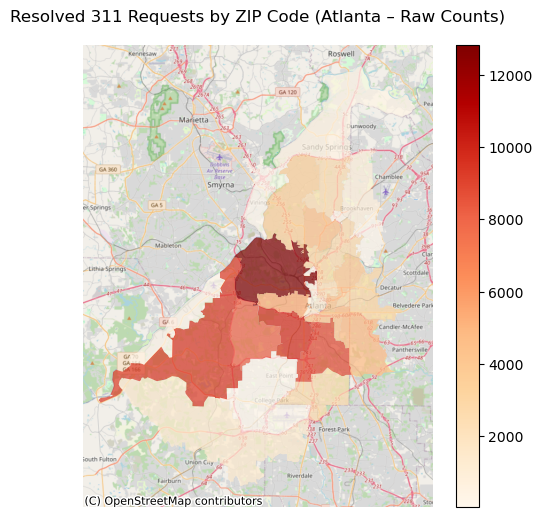

In [88]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

zcta_atl_web.plot(
    column='total_resolved',
    cmap='OrRd',
    linewidth=0.3,
    ax=ax,
    legend=True,
    alpha=0.7
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik
)

ax.set_title("Resolved 311 Requests by ZIP Code (Atlanta – Raw Counts)")
ax.axis('off')

plt.show()


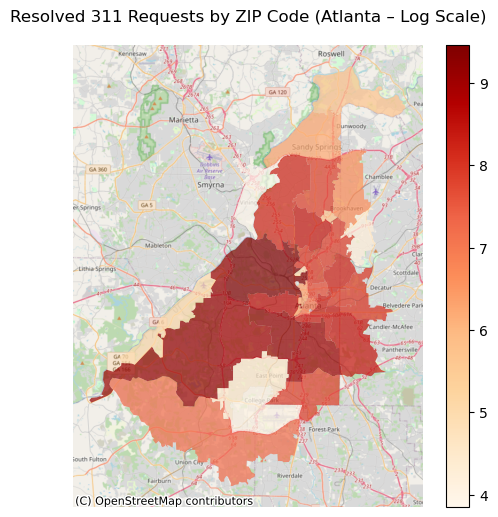

In [89]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

zcta_atl_web.plot(
    column='log_total_resolved',
    cmap='OrRd',
    linewidth=0.3,
    ax=ax,
    legend=True,
    alpha=0.7
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik
)

ax.set_title("Resolved 311 Requests by ZIP Code (Atlanta – Log Scale)")
ax.axis('off')

plt.show()


In [78]:
import contextily as ctx

zcta_atl_web = zcta_atl.to_crs(epsg=3857)


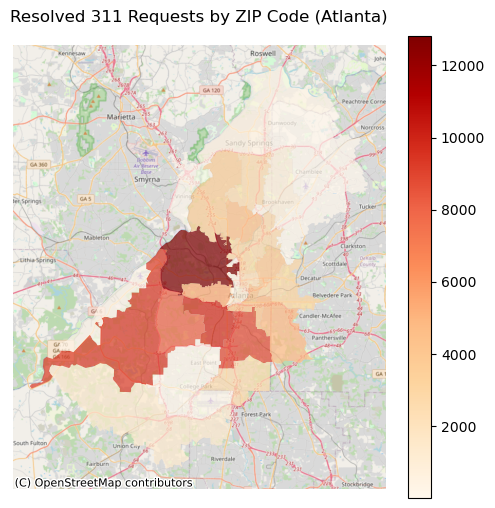

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)

# Plot ZIP polygons
zcta_atl_web.plot(
    column='total_resolved',
    cmap='OrRd',
    linewidth=0.3,
    ax=ax,
    legend=True,
    alpha=0.7  # important so basemap is visible
)

# Add basemap underneath
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik
)

ax.set_title("Resolved 311 Requests by ZIP Code (Atlanta)")
ax.axis('off')

plt.show()


In [37]:
atl_zip_resp = zip_responsiveness[
    (zip_responsiveness['zip_clean'].str.startswith('303'))
].copy()


In [38]:
atl_zip_resp[['total_resolved', 'median_resolution_hours']].describe()


,total_resolved,median_resolution_hours
count,49.000000,49.000000
mean,2025.020408,91.615136
std,3088.564361,357.274932
min,1.000000,0.066667
25%,10.000000,20.683333
50%,295.000000,28.791667
75%,2950.000000,49.758333
max,12816.000000,2520.100000


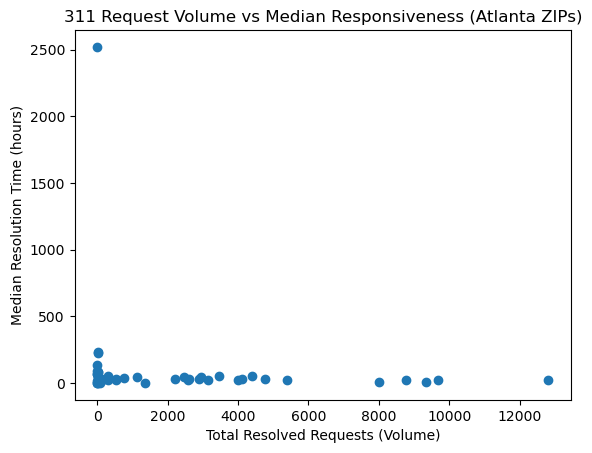

In [39]:
plt.figure()

plt.scatter(
    atl_zip_resp['total_resolved'],
    atl_zip_resp['median_resolution_hours']
)

plt.xlabel("Total Resolved Requests (Volume)")
plt.ylabel("Median Resolution Time (hours)")
plt.title("311 Request Volume vs Median Responsiveness (Atlanta ZIPs)")

plt.show()


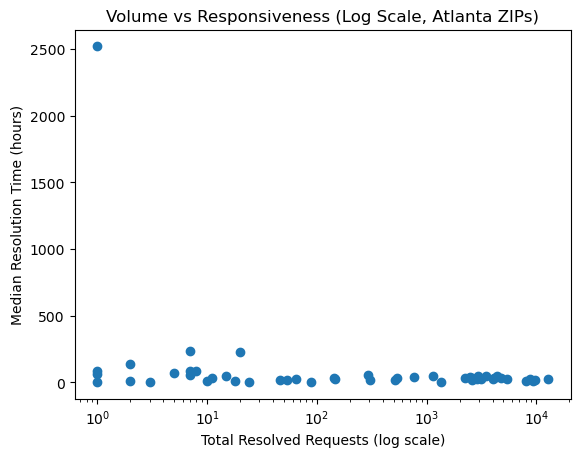

In [40]:
plt.figure()

plt.scatter(
    atl_zip_resp['total_resolved'],
    atl_zip_resp['median_resolution_hours']
)

plt.xscale('log')

plt.xlabel("Total Resolved Requests (log scale)")
plt.ylabel("Median Resolution Time (hours)")
plt.title("Volume vs Responsiveness (Log Scale, Atlanta ZIPs)")

plt.show()


In [41]:
atl_zip_resp[['total_resolved', 'median_resolution_hours']].corr()


,total_resolved,median_resolution_hours
total_resolved,1.000000,-0.125422
median_resolution_hours,-0.125422,1.000000


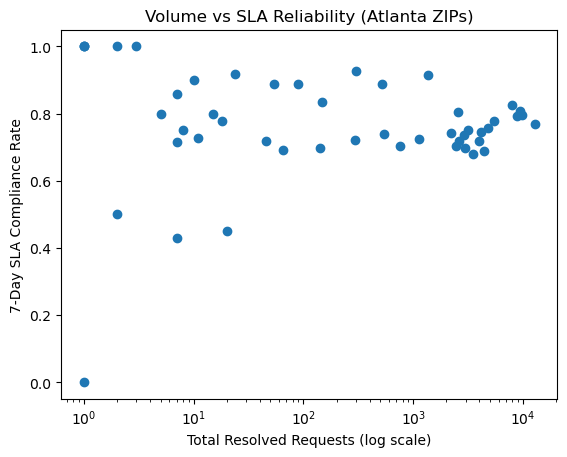

In [42]:
plt.figure()

plt.scatter(
    atl_zip_resp['total_resolved'],
    atl_zip_resp['sla_7day_rate']
)

plt.xscale('log')

plt.xlabel("Total Resolved Requests (log scale)")
plt.ylabel("7-Day SLA Compliance Rate")
plt.title("Volume vs SLA Reliability (Atlanta ZIPs)")

plt.show()


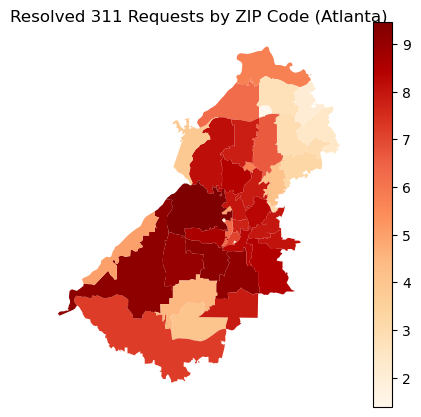

In [44]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(5, 5),  # smaller
    dpi=100          # explicit lower DPI
)

zcta_atl.plot(
    column='log_total_resolved',
    cmap='OrRd',
    linewidth=0.2,
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)

ax.set_title("Resolved 311 Requests by ZIP Code (Atlanta)")
ax.axis('off')

plt.show()


In [45]:
df['zip_clean'] = (
    df['Zip Code']
    .astype(str)
    .str.extract(r'(\d{5})')
)

atl_df = df[
    df['zip_clean'].str.startswith('303', na=False)
].copy()


In [46]:
atl_df = atl_df[
    atl_df['Status'].isin(['Active', 'Resolved'])
]


In [47]:
zip_status_counts = (
    atl_df
    .groupby(['zip_clean', 'Status'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

zip_status_counts.head()


Status,zip_clean,Active,Resolved
0,30301,2,3
1,30303,357,1133
2,30304,2,11
3,30305,816,4390
4,30306,621,4006


In [48]:
zip_status_counts['total'] = (
    zip_status_counts['Active'] +
    zip_status_counts['Resolved']
)

In [49]:
zip_status_counts = zip_status_counts.sort_values(
    'total',
    ascending=False
)


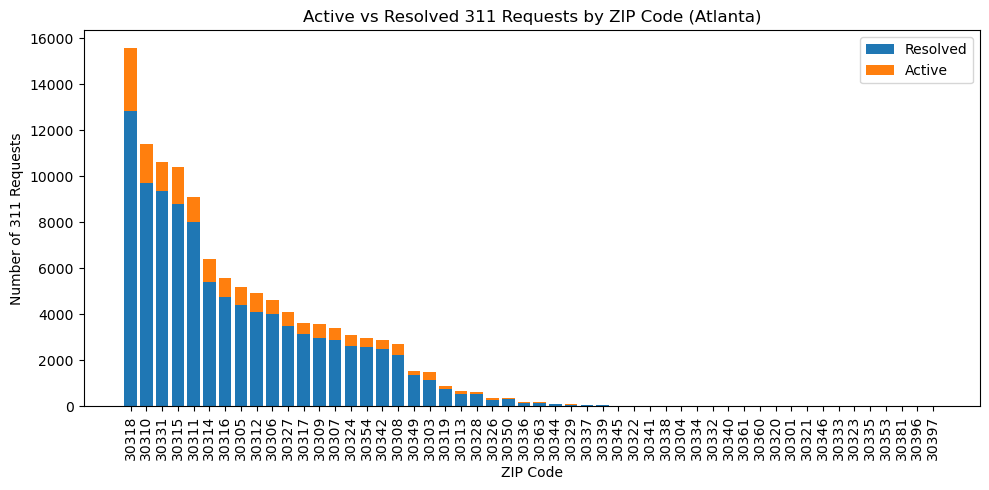

In [50]:
plt.figure(figsize=(10, 5))

x = range(len(zip_status_counts))

plt.bar(
    x,
    zip_status_counts['Resolved'],
    label='Resolved'
)

plt.bar(
    x,
    zip_status_counts['Active'],
    bottom=zip_status_counts['Resolved'],
    label='Active'
)

plt.xticks(
    x,
    zip_status_counts['zip_clean'],
    rotation=90
)

plt.ylabel("Number of 311 Requests")
plt.xlabel("ZIP Code")
plt.title("Active vs Resolved 311 Requests by ZIP Code (Atlanta)")
plt.legend()

plt.tight_layout()
plt.show()


In [51]:
zip_status_counts['active_ratio'] = (
    zip_status_counts['Active'] /
    (zip_status_counts['Active'] + zip_status_counts['Resolved'])
)


In [52]:
zcta = gpd.read_file("../data/zcta/cb_2018_us_zcta510_500k.shp")
zcta['zip_clean'] = zcta['ZCTA5CE10'].astype(str)

zcta_atl = zcta[
    zcta['zip_clean'].str.startswith('303')
].copy()


In [53]:
zcta_atl = zcta_atl.merge(
    zip_status_counts[['zip_clean', 'active_ratio']],
    on='zip_clean',
    how='left'
)


In [54]:
zcta_atl['geometry'] = zcta_atl['geometry'].simplify(
    tolerance=0.001,
    preserve_topology=True
)


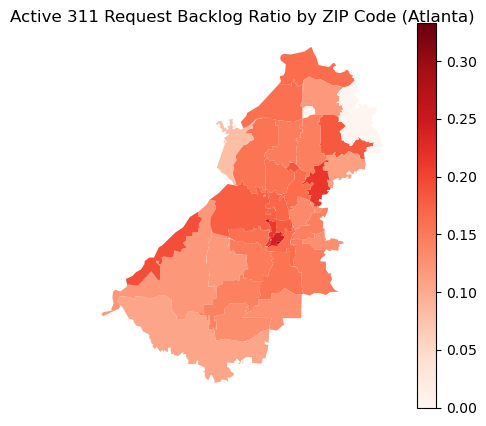

In [55]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

zcta_atl.plot(
    column='active_ratio',
    cmap='Reds',
    linewidth=0.2,
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)

ax.set_title("Active 311 Request Backlog Ratio by ZIP Code (Atlanta)")
ax.axis('off')

plt.show()


In [91]:
zip_status_counts['active_ratio'] = (
    zip_status_counts['Active'] /
    (zip_status_counts['Active'] + zip_status_counts['Resolved'])
)


In [92]:
zip_status_counts['total'] = (
    zip_status_counts['Active'] + zip_status_counts['Resolved']
)

zip_status_filt = zip_status_counts[
    zip_status_counts['total'] >= 25
].copy()


In [93]:
zcta_atl_backlog = zcta_atl.merge(
    zip_status_filt[['zip_clean', 'active_ratio', 'total']],
    on='zip_clean',
    how='inner'
)


In [94]:
zcta_atl_web = zcta_atl_backlog.to_crs(epsg=3857)

zcta_atl_web['geometry'] = zcta_atl_web['geometry'].simplify(
    tolerance=50,
    preserve_topology=True
)


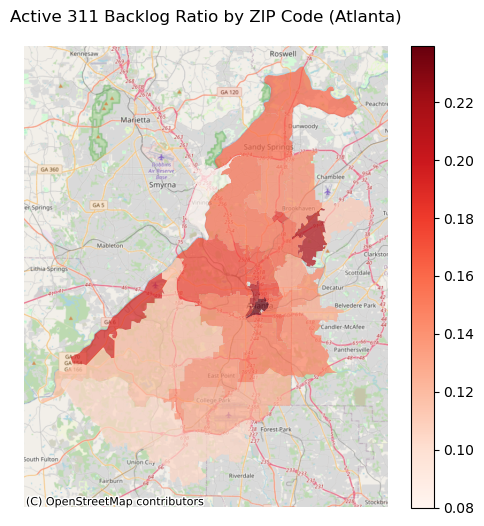

In [95]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

zcta_atl_web.plot(
    column='active_ratio',
    cmap='Reds',
    linewidth=0.3,
    ax=ax,
    legend=True,
    alpha=0.7
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik
)

ax.set_title("Active 311 Backlog Ratio by ZIP Code (Atlanta)")
ax.axis('off')

plt.show()


In [96]:
zip_bar = zip_status_counts[
    (zip_status_counts['zip_clean'].str.startswith('303')) &
    ((zip_status_counts['Active'] + zip_status_counts['Resolved']) >= 25)
].copy()


In [97]:
zip_bar['total'] = zip_bar['Active'] + zip_bar['Resolved']

zip_bar = zip_bar.sort_values(
    'total',
    ascending=False
)


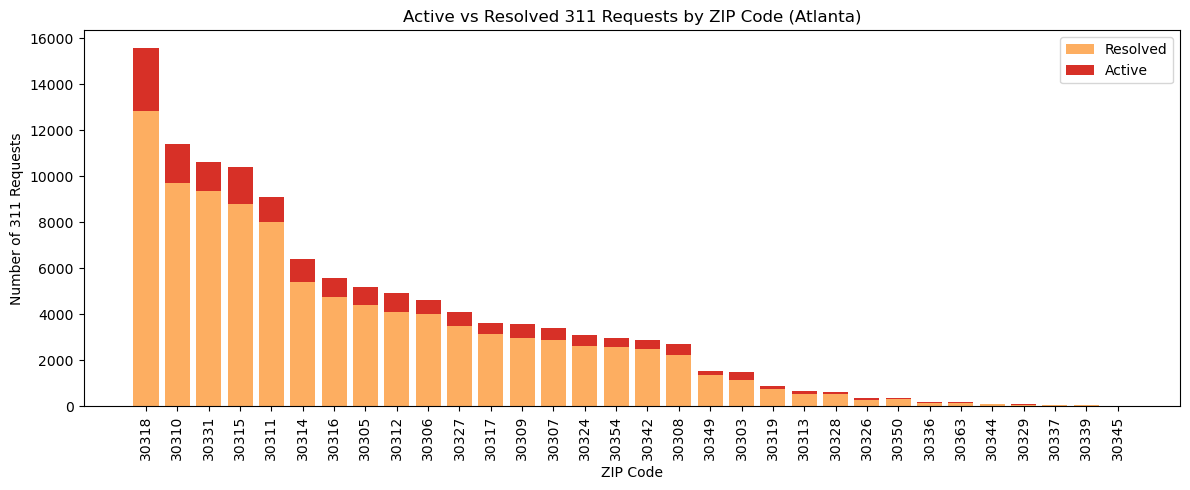

In [98]:
plt.figure(figsize=(12, 5), dpi=100)

plt.bar(
    zip_bar['zip_clean'],
    zip_bar['Resolved'],
    label='Resolved',
    color='#fdae61'
)

plt.bar(
    zip_bar['zip_clean'],
    zip_bar['Active'],
    bottom=zip_bar['Resolved'],
    label='Active',
    color='#d73027'
)

plt.xticks(rotation=90)
plt.ylabel("Number of 311 Requests")
plt.xlabel("ZIP Code")
plt.title("Active vs Resolved 311 Requests by ZIP Code (Atlanta)")
plt.legend()

plt.tight_layout()
plt.show()


In [99]:
zip_bar['active_ratio'] = (
    zip_bar['Active'] / zip_bar['total']
)


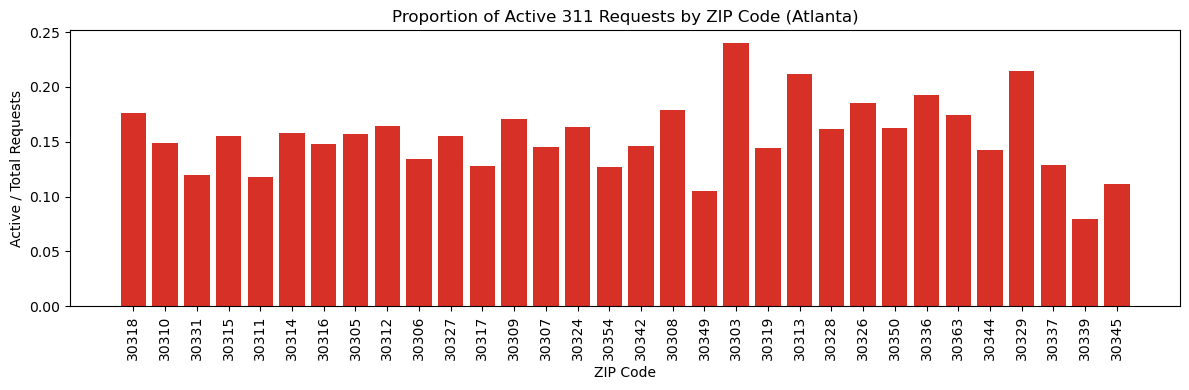

In [100]:
plt.figure(figsize=(12, 4), dpi=100)

plt.bar(
    zip_bar['zip_clean'],
    zip_bar['active_ratio'],
    color='#d73027'
)

plt.xticks(rotation=90)
plt.ylabel("Active / Total Requests")
plt.xlabel("ZIP Code")
plt.title("Proportion of Active 311 Requests by ZIP Code (Atlanta)")

plt.tight_layout()
plt.show()


In [ ]:
#### Issue analysis


In [104]:
# df['Short Description'].value_counts().head(30)
df['Short Description'].nunique()



963

In [116]:
issue_table = (
    df['Short Description']
    .value_counts()
    .reset_index()
    .rename(columns={
        'index': 'issue_description',
        'Short Description': 'descriptions'
    })
)

issue_table.head()


,descriptions,count
0,Account Information For Active Water And Sewer...,28185
1,When is my court date and time?,21055
2,I Failed to Appear at Court,20329
3,Bulk Collection Request,18847
4,Dropped Call / Case Created In Error,17899


In [117]:
issue_table


,descriptions,count
0,Account Information For Active Water And Sewer...,28185
1,When is my court date and time?,21055
2,I Failed to Appear at Court,20329
3,Bulk Collection Request,18847
4,Dropped Call / Case Created In Error,17899
...,...,...
958,"Concrete Inspection on Sidewalk, Curb or Drive...",1
959,Bicycle Rack and Bicycle Mural Requests/Instal...,1
960,ONE Musicfest,1
961,How to Receive Completed Information Requests ...,1


In [107]:
issue_table.to_csv("2025_311_issue_descriptions.csv", index=False)


In [108]:
CATEGORY_KEYWORDS = {
    "Court & Legal": [
        "court", "citation", "ticket", "warrant", "fine", "plea",
        "probation", "arraignment", "judge", "appeared", "municipal court"
    ],

    "Water & Sewer": [
        "water", "sewer", "hydrant", "meter", "leak", "pressure",
        "no water", "billing", "account", "bill", "refund"
    ],

    "Solid Waste & Sanitation": [
        "garbage", "trash", "recycling", "bulk", "cart",
        "yard trimmings", "dumping", "street sweeping"
    ],

    "Transportation & Right-of-Way": [
        "pothole", "traffic", "signal", "street", "sidewalk",
        "curb", "crosswalk", "road", "sign", "light"
    ],

    "Code Enforcement & Property": [
        "code enforcement", "overgrowth", "junk", "vacant",
        "unsafe", "mold", "rodent", "no heat", "no air"
    ],

    "Business, Permits & Licensing": [
        "business", "permit", "license", "occupation tax",
        "renewal", "zoning", "inspection", "certificate"
    ],

    "Public Safety (Non-Emergency)": [
        "police", "alarm", "noise", "stolen", "suspicious",
        "pad", "welfare", "crime", "report"
    ],

    "Housing & Social Services": [
        "housing", "homeless", "shelter", "rent",
        "eviction", "assistance", "mental health", "food"
    ],

    "Parks, Trees & Environment": [
        "tree", "park", "erosion", "stormwater",
        "flood", "environment", "creek", "green"
    ],

    "Information / Routing / Noise": [
        "dropped call", "directory", "transfer",
        "contact us", "chat", "wrong queue"
    ]
}


In [109]:
df['desc_clean'] = (
    df['Short Description']
    .str.lower()
    .str.replace(r'[^a-z0-9 ]', '', regex=True)
)


In [110]:
def classify_description(desc):
    for category, keywords in CATEGORY_KEYWORDS.items():
        for kw in keywords:
            if kw in desc:
                return category
    return "Other / Unclassified"

In [111]:
df['issue_category'] = df['desc_clean'].apply(classify_description)


In [112]:
df['issue_category'].value_counts()


issue_category
Court & Legal                    82521
Water & Sewer                    80184
Solid Waste & Sanitation         74813
Information / Routing / Noise    36252
Other / Unclassified             29650
Business, Permits & Licensing    22199
Transportation & Right-of-Way    20185
Code Enforcement & Property      11772
Housing & Social Services        11243
Public Safety (Non-Emergency)     8681
Parks, Trees & Environment        1522
Name: count, dtype: int64

In [113]:
(
    df[df['issue_category'] == "Other / Unclassified"]
    ['Short Description']
    .value_counts()
    .head(30)
)


Short Description
Service Complaint - Department of Public Works (DPW)                        2281
What is the pretrial intervention program?                                  1586
What is my Solid Waste Collection Day?                                      1521
912 Release Request                                                         1415
What happens when my case is bound over?                                    1334
Right of Way Maintenance (ROW) Litter Removal                               1299
Dead Animal Removal                                                         1285
Solid Waste Education and Enforcement Team (SWEET) Investigation Request    1058
Submit a Claim for Damages with City of Atlanta                              904
How do I contact the Solicitors Office for the City of Atlanta?              887
Remove Obstruction in the Right of Way (ROW)                                 807
Contact the City of Atlanta Human Resources Department                       796
Verify Add

In [118]:
df['zip_clean']


0         30331
1         30306
2         30314
3         30313
4         30317
          ...  
379017      NaN
379018    30315
379019      NaN
379020    30315
379021    30313
Name: zip_clean, Length: 379022, dtype: object

In [119]:
zip_counts = (
    df
    .dropna(subset=['zip_clean'])
    .groupby('zip_clean')
    .size()
    .reset_index(name='total_requests')
)


In [120]:
zip_counts['total_requests'].describe()


count      192.000000
mean       623.619792
std       2129.206360
min          1.000000
25%          1.000000
50%          2.000000
75%         10.250000
max      15837.000000
Name: total_requests, dtype: float64

In [121]:
zip_counts['request_density_norm'] = (
    zip_counts['total_requests'] - zip_counts['total_requests'].min()
) / (
    zip_counts['total_requests'].max() - zip_counts['total_requests'].min()
)


In [122]:
zip_counts['request_density_log'] = np.log1p(zip_counts['total_requests'])


In [123]:
zip_counts['request_density_log_norm'] = (
    zip_counts['request_density_log'] - zip_counts['request_density_log'].min()
) / (
    zip_counts['request_density_log'].max() - zip_counts['request_density_log'].min()
)


In [124]:
zip_counts.sort_values('total_requests', ascending=False).head(10)


,zip_clean,total_requests,request_density_norm,request_density_log,request_density_log_norm
112,30318,15837,1.000000,9.670167,1.000000
104,30310,11538,0.728530,9.353488,0.964723
123,30331,10744,0.678391,9.282196,0.956782
109,30315,10531,0.664941,9.262174,0.954551
105,30311,9147,0.577545,9.121291,0.938858
108,30314,6516,0.411404,8.782169,0.901081
110,30316,5651,0.356782,8.639765,0.885218
99,30305,5247,0.331271,8.565602,0.876956
106,30312,4977,0.314221,8.512783,0.871073
100,30306,4681,0.295529,8.451481,0.864244


In [125]:
zip_counts.sort_values('total_requests').head(10)


,zip_clean,total_requests,request_density_norm,request_density_log,request_density_log_norm
0,10004,1,0.0,0.693147,0.0
2,10024,1,0.0,0.693147,0.0
3,10451,1,0.0,0.693147,0.0
5,21227,1,0.0,0.693147,0.0
7,23462,1,0.0,0.693147,0.0
6,22908,1,0.0,0.693147,0.0
9,27411,1,0.0,0.693147,0.0
8,24801,1,0.0,0.693147,0.0
12,28110,1,0.0,0.693147,0.0
13,28500,1,0.0,0.693147,0.0


In [126]:
atl_zip_counts = zip_counts[
    zip_counts['zip_clean'].str.startswith('303')
].copy()


In [ ]:
atl_zip_counts.shape
zcta['zip_clean'] = zcta['ZCTA5CE10'].astype(str)
zcta_atl = zcta[zcta['zip_clean'].str.startswith('303')]
zcta_atl = zcta_atl.merge(
    atl_zip_counts,
    on='zip_clean',
    how='left'
)


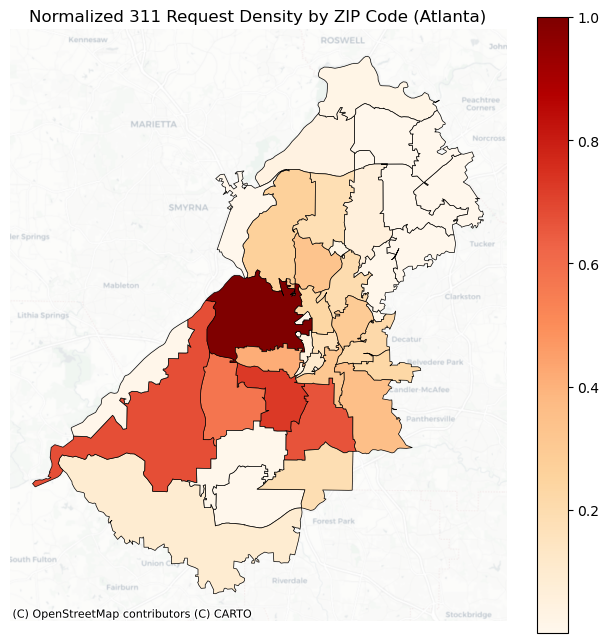

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot ZIP polygons
zcta_atl.plot(
    column='request_density_norm',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=zcta_atl.crs,
    alpha=0.6
)

ax.set_title("Normalized 311 Request Density by ZIP Code (Atlanta)")
ax.axis('off')

plt.show()


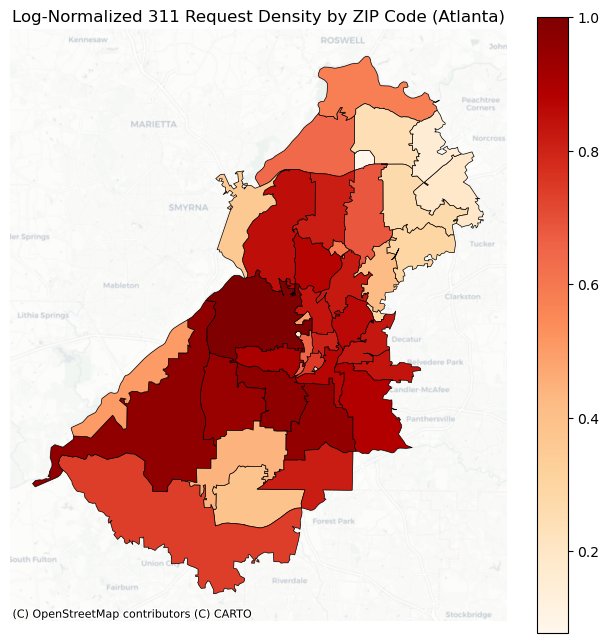

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

zcta_atl.plot(
    column='request_density_log_norm',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=zcta_atl.crs,
    alpha=0.6
)

ax.set_title("Log-Normalized 311 Request Density by ZIP Code (Atlanta)")
ax.axis('off')

plt.show()


In [169]:
sla_thresholds = {
    "3d": 3 * 24,
    "7d": 7 * 24,
    "14d": 14 * 24,
    "30d": 30 * 24
}


In [170]:
sla_by_zip = (
    resolved_df_ga
    .groupby('zip_clean')
    .apply(
        lambda g: pd.Series({
            f"sla_{k}": (g['resolution_time_hours'] <= v).mean()
            for k, v in sla_thresholds.items()
        })
    )
    .reset_index()
)


C:\Users\shrey\AppData\Local\Temp\ipykernel_10292\2960996495.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [171]:
zip_volume = (
    resolved_df_ga
    .groupby('zip_clean')
    .size()
    .reset_index(name='total_resolved')
)

sla_by_zip = sla_by_zip.merge(zip_volume, on='zip_clean')

sla_by_zip = sla_by_zip[sla_by_zip['total_resolved'] >= 25]


In [172]:
sla_by_zip[['sla_3d', 'sla_7d', 'sla_14d', 'sla_30d']].describe()


,sla_3d,sla_7d,sla_14d,sla_30d
count,36.000000,36.000000,36.000000,36.000000
mean,0.666195,0.783153,0.869135,0.927778
std,0.105982,0.087355,0.056327,0.031838
min,0.416667,0.633333,0.723077,0.846154
25%,0.584992,0.718621,0.828827,0.910080
50%,0.642305,0.753619,0.866787,0.933836
75%,0.737183,0.848622,0.912965,0.951260
max,0.858696,0.945652,0.981481,0.981481


In [173]:
sla_by_zip['delta_3d_to_7d'] = sla_by_zip['sla_7d'] - sla_by_zip['sla_3d']
sla_by_zip['delta_7d_to_14d'] = sla_by_zip['sla_14d'] - sla_by_zip['sla_7d']


In [174]:
sla_by_zip.sort_values('sla_30d').head(10)


,zip_clean,sla_3d,sla_7d,sla_14d,sla_30d,total_resolved,delta_3d_to_7d,delta_7d_to_14d
101,30329,0.630769,0.692308,0.723077,0.846154,65,0.061538,0.030769
86,30313,0.595149,0.738806,0.800373,0.854478,536,0.143657,0.061567
109,30339,0.717391,0.717391,0.804348,0.869565,46,0.000000,0.086957
76,30303,0.568021,0.723498,0.806537,0.872792,1132,0.155477,0.083039
121,30363,0.549296,0.697183,0.830986,0.887324,142,0.147887,0.133803
12,30032,0.416667,0.633333,0.800000,0.900000,60,0.216667,0.166667
99,30327,0.545952,0.680784,0.818784,0.901757,3471,0.134831,0.138001
78,30305,0.553555,0.689152,0.819964,0.907475,4388,0.135597,0.130811
82,30309,0.580000,0.698644,0.822034,0.909492,2950,0.118644,0.123390
97,30324,0.586656,0.719325,0.831288,0.910276,2608,0.132669,0.111963


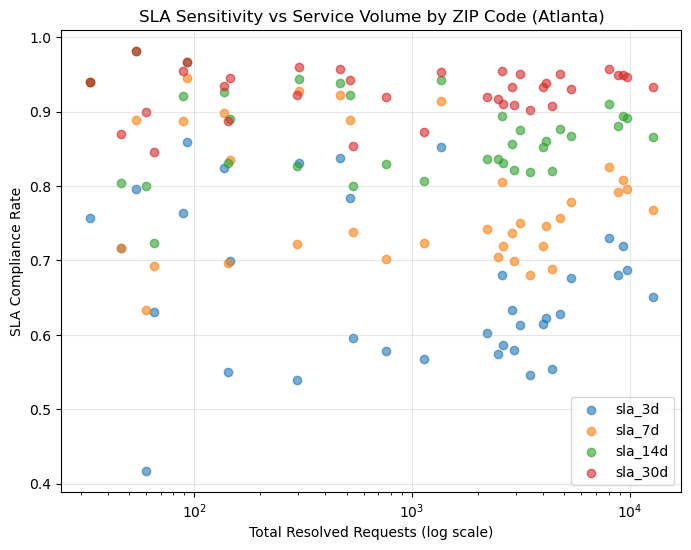

In [175]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for sla in ['sla_3d', 'sla_7d', 'sla_14d', 'sla_30d']:
    plt.scatter(
        sla_by_zip['total_resolved'],
        sla_by_zip[sla],
        alpha=0.6,
        label=sla
    )

plt.xscale('log')
plt.xlabel("Total Resolved Requests (log scale)")
plt.ylabel("SLA Compliance Rate")
plt.title("SLA Sensitivity vs Service Volume by ZIP Code (Atlanta)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [176]:
sla_by_zip[
    (sla_by_zip['sla_3d'] < 0.6) &
    (sla_by_zip['sla_30d'] > 0.9)
]


,zip_clean,sla_3d,sla_7d,sla_14d,sla_30d,total_resolved,delta_3d_to_7d,delta_7d_to_14d
78,30305,0.553555,0.689152,0.819964,0.907475,4388,0.135597,0.130811
82,30309,0.580000,0.698644,0.822034,0.909492,2950,0.118644,0.123390
92,30319,0.578740,0.702100,0.829396,0.919948,762,0.123360,0.127297
97,30324,0.586656,0.719325,0.831288,0.910276,2608,0.132669,0.111963
98,30326,0.538983,0.722034,0.827119,0.922034,295,0.183051,0.105085
99,30327,0.545952,0.680784,0.818784,0.901757,3471,0.134831,0.138001
112,30342,0.574838,0.704288,0.836570,0.916667,2472,0.129450,0.132282


In [177]:
sla_plot_df = sla_by_zip[
    sla_by_zip['total_resolved'] >= 25
].copy()

sla_plot_df['zip_clean'] = sla_plot_df['zip_clean'].astype(str)


In [178]:
zcta_atl['zip_clean'] = zcta_atl['ZCTA5CE10'].astype(str)
zcta_sla = zcta_atl.merge(
    sla_plot_df,
    on='zip_clean',
    how='left'
)



In [179]:
zcta_sla_3857 = zcta_sla.to_crs(epsg=3857)



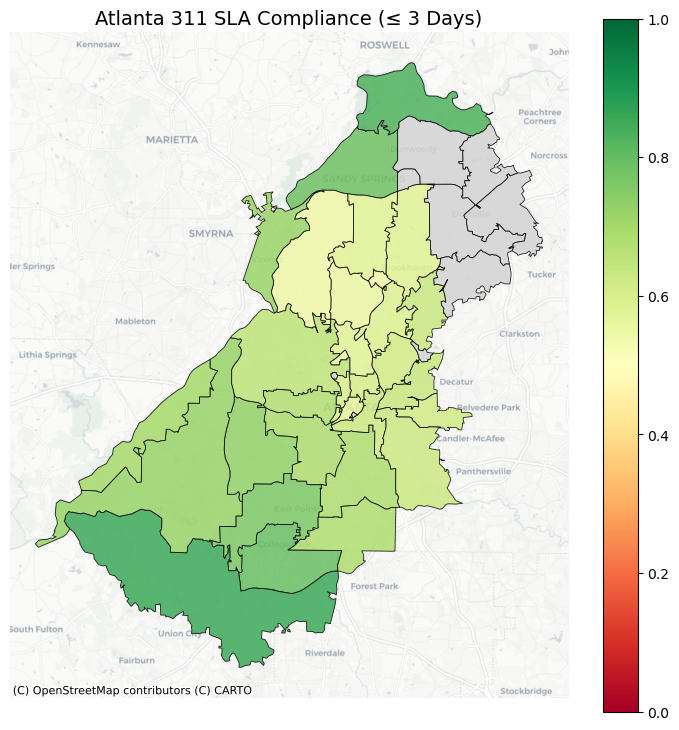

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Plot ZIP polygons with SLA coloring
zcta_sla_3857.plot(
    column='sla_3d',
    cmap='RdYlGn',
    linewidth=0.6,
    edgecolor='black',
    ax=ax,
    legend=True,
    alpha=0.85,
    vmin=0,
    vmax=1,
    missing_kwds={
        "color": "lightgrey",
        "label": "Insufficient data"
    }
)

# Add basemap underneath
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  # clean, presentation-friendly
    zoom=11
)

ax.set_title("Atlanta 311 SLA Compliance (≤ 3 Days)", fontsize=14)
ax.axis('off')

plt.show()


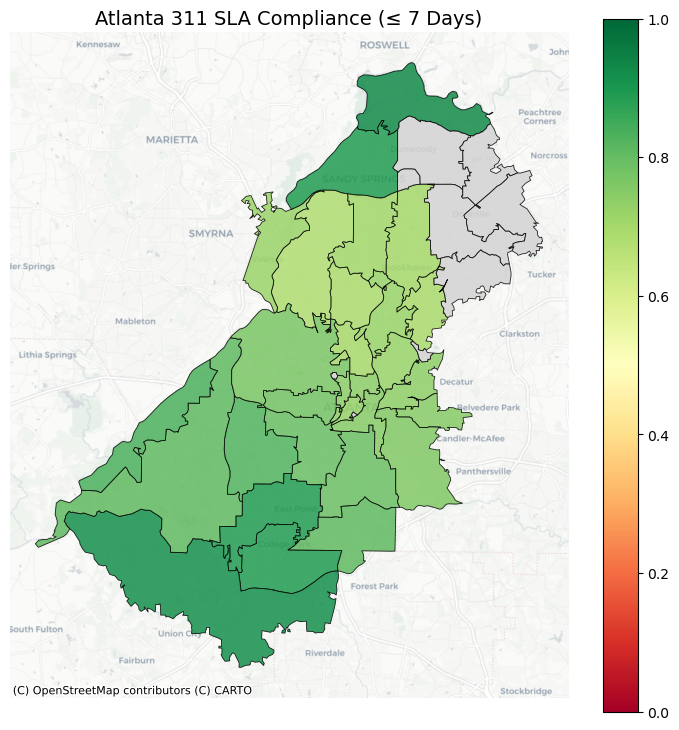

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

zcta_sla_3857.plot(
    column='sla_7d',
    cmap='RdYlGn',
    linewidth=0.6,
    edgecolor='black',
    ax=ax,
    legend=True,
    alpha=0.85,
    vmin=0,
    vmax=1,
    missing_kwds={
        "color": "lightgrey",
        "label": "Insufficient data"
    }
)

ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    zoom=11
)

ax.set_title("Atlanta 311 SLA Compliance (≤ 7 Days)", fontsize=14)
ax.axis('off')

plt.show()
